In [3]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [4]:
!pip install sagemaker ipywidgets --upgrade --quiet

In [5]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [7]:
# Retrieve training artifacts

from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "catboost-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

train_image_uri = image_uris.retrieve(region=None, framework=None, model_id=train_model_id, model_version=train_model_version, image_scope=train_scope, instance_type=training_instance_type)

train_source_uri = script_uris.retrieve(model_id=train_model_id, model_version=train_model_version, script_scope=train_scope)

train_model_uri = model_uris.retrieve(model_id=train_model_id, model_version=train_model_version, model_scope=train_scope)

In [8]:
# Specifying paths of training data and model output data

training_data_bucket = "csis-4495-tcga"
training_data_prefix = "train/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = "sagemaker-tcga-catboost"
output_prefix = "tcga-catboost-jumpstart/"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [37]:
from sagemaker import hyperparameters

hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# Overiding hyperparameters identified in local training. Local training located in Model folder

hyperparameters['random_strength'] = "2"
hyperparameters['depth'] = "5"
hyperparameters['l2_leaf_reg'] = "1"
hyperparameters['iterations'] = "100"
hyperparameters['learning_rate'] = "0.3"
hyperparameters['eval_metric'] = "MultiClass"

print(hyperparameters)

{'iterations': '100', 'early_stopping_rounds': '5', 'eval_metric': 'MultiClass', 'learning_rate': '0.3', 'depth': '5', 'l2_leaf_reg': '1', 'random_strength': '2', 'max_leaves': '31', 'rsm': '1', 'sampling_frequency': 'PerTreeLevel', 'min_data_in_leaf': '1', 'bagging_temperature': '1', 'boosting_type': 'Auto', 'scale_pos_weight': '1.0', 'max_bin': 'Auto', 'grow_policy': 'SymmetricTree', 'random_seed': '0', 'thread_count': '-1', 'verbose': '1'}


In [38]:
# Start training
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

tabular_estimator.fit(
    {"training": training_dataset_s3_path}, logs=False, job_name=training_job_name
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: jumpstart-catboost-classification-model-2023-11-14-01-35-32-204



2023-11-14 01:35:37 Starting - Starting the training job..
2023-11-14 01:35:51 Starting - Preparing the instances for training............
2023-11-14 01:36:54 Downloading - Downloading input data....
2023-11-14 01:37:19 Training - Downloading the training image......
2023-11-14 01:37:55 Training - Training image download completed. Training in progress......
2023-11-14 01:38:25 Uploading - Uploading generated training model.
2023-11-14 01:38:36 Completed - Training job completed


In [40]:
# Deploy and run inference on the trained model to test that the endpoint is working

inference_instance_type = "ml.m5.large"

deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = "tcga-catboost-endpoint"

predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-tcga-catboost/tcga-catboost-jumpstart//output/jumpstart-catboost-classification-model-2023-11-14-01-35-32-204/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-west-2/source-directory-tarballs/catboost/inference/classification/v1.1.1/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-031114635023/sagemaker-jumpstart-2023-11-14-01-39-33-781/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-11-14-01-39-33-781
INFO:sagemaker:Creating endpoint-config with name tcga-catboost-endpoint
INFO:sagemaker:Creating endpoint with name tcga-catboost-endpoint


------!

In [41]:
# Download the validation data set for evaluation

validation_data_bucket = "csis-4495-tcga"
validation_data_prefix = "validation"
validation_data_file_name = "data.csv"

boto3.client("s3").download_file(
    validation_data_bucket, f"{validation_data_prefix}/{validation_data_file_name}", validation_data_file_name
)

In [42]:
# Testing the endpoint
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Read the data
test_data = pd.read_csv(validation_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature+{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print( f"The test dataset contains {num_examples} examples and {num_columns} columns.\n" )

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"The first 5 observations of the data: \n")
test_data.head(5)

The test dataset contains 1002 examples and 53 columns.

The first 5 observations of the data: 



,Target,Feature+1,Feature+2,Feature+3,Feature+4,Feature+5,Feature+6,Feature+7,Feature+8,Feature+9,...,Feature+43,Feature+44,Feature+45,Feature+46,Feature+47,Feature+48,Feature+49,Feature+50,Feature+51,Feature+52
0,0,0,63,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,58,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,7,1,54,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,48,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,3,0,50,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
# Querying endpoint for further testing
content_type = "text/csv"

def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)

# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(
    predict_prob, axis=1
)

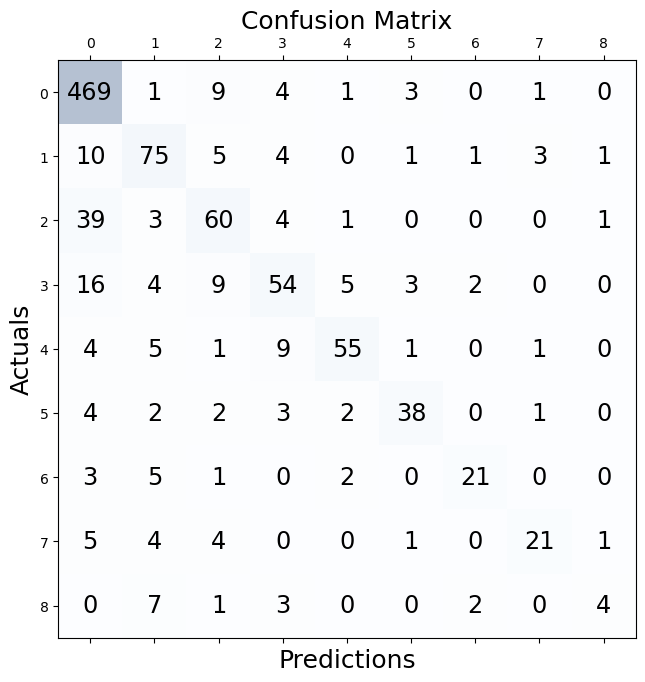

In [44]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [45]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print(
    f"Evaluation result on test data: \n"
    f"{accuracy_score.__name__}: {eval_accuracy} \n"
    f"F1 Macro: {eval_f1_macro} \n"
    f"F1 Micro: {eval_f1_micro}"
)

Evaluation result on test data: 
accuracy_score: 0.7954091816367266 
F1 Macro: 0.6798853852592532 
F1 Micro: 0.7954091816367265
